## Задание 1

### Шаг 1: Загрузка необходимых библиотек и датасета

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для построения дерева решений
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Для градиентного бустинга
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Для случайного леса
from sklearn.ensemble import RandomForestClassifier

# Для визуализации дерева
import graphviz
from sklearn import tree

# Настройка отображения графиков
%matplotlib inline
sns.set(style="whitegrid")

### Шаг 2: Загрузка датасета

In [4]:
# Ссылка на датасет
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# Чтение Excel-файла
df = pd.read_excel(url, header=1)

# Первые 5 строк
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Шаг 3: Предварительный анализ данных

Количество наблюдений: 30000
Количество признаков: 25
Пропущенные значения в признаках:
Series([], dtype: int64)
Категориальные признаки (0): []
Числовые признаки (25): ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


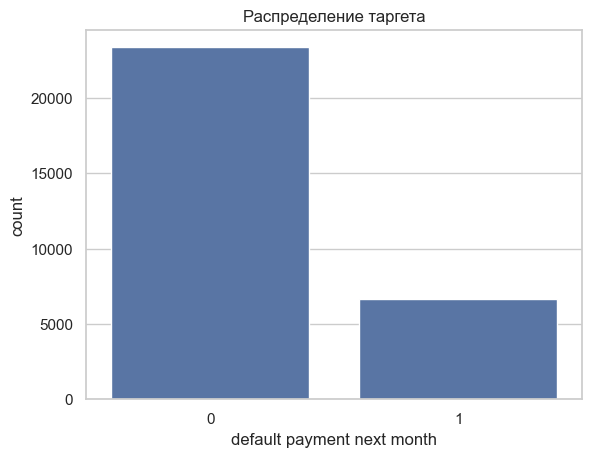

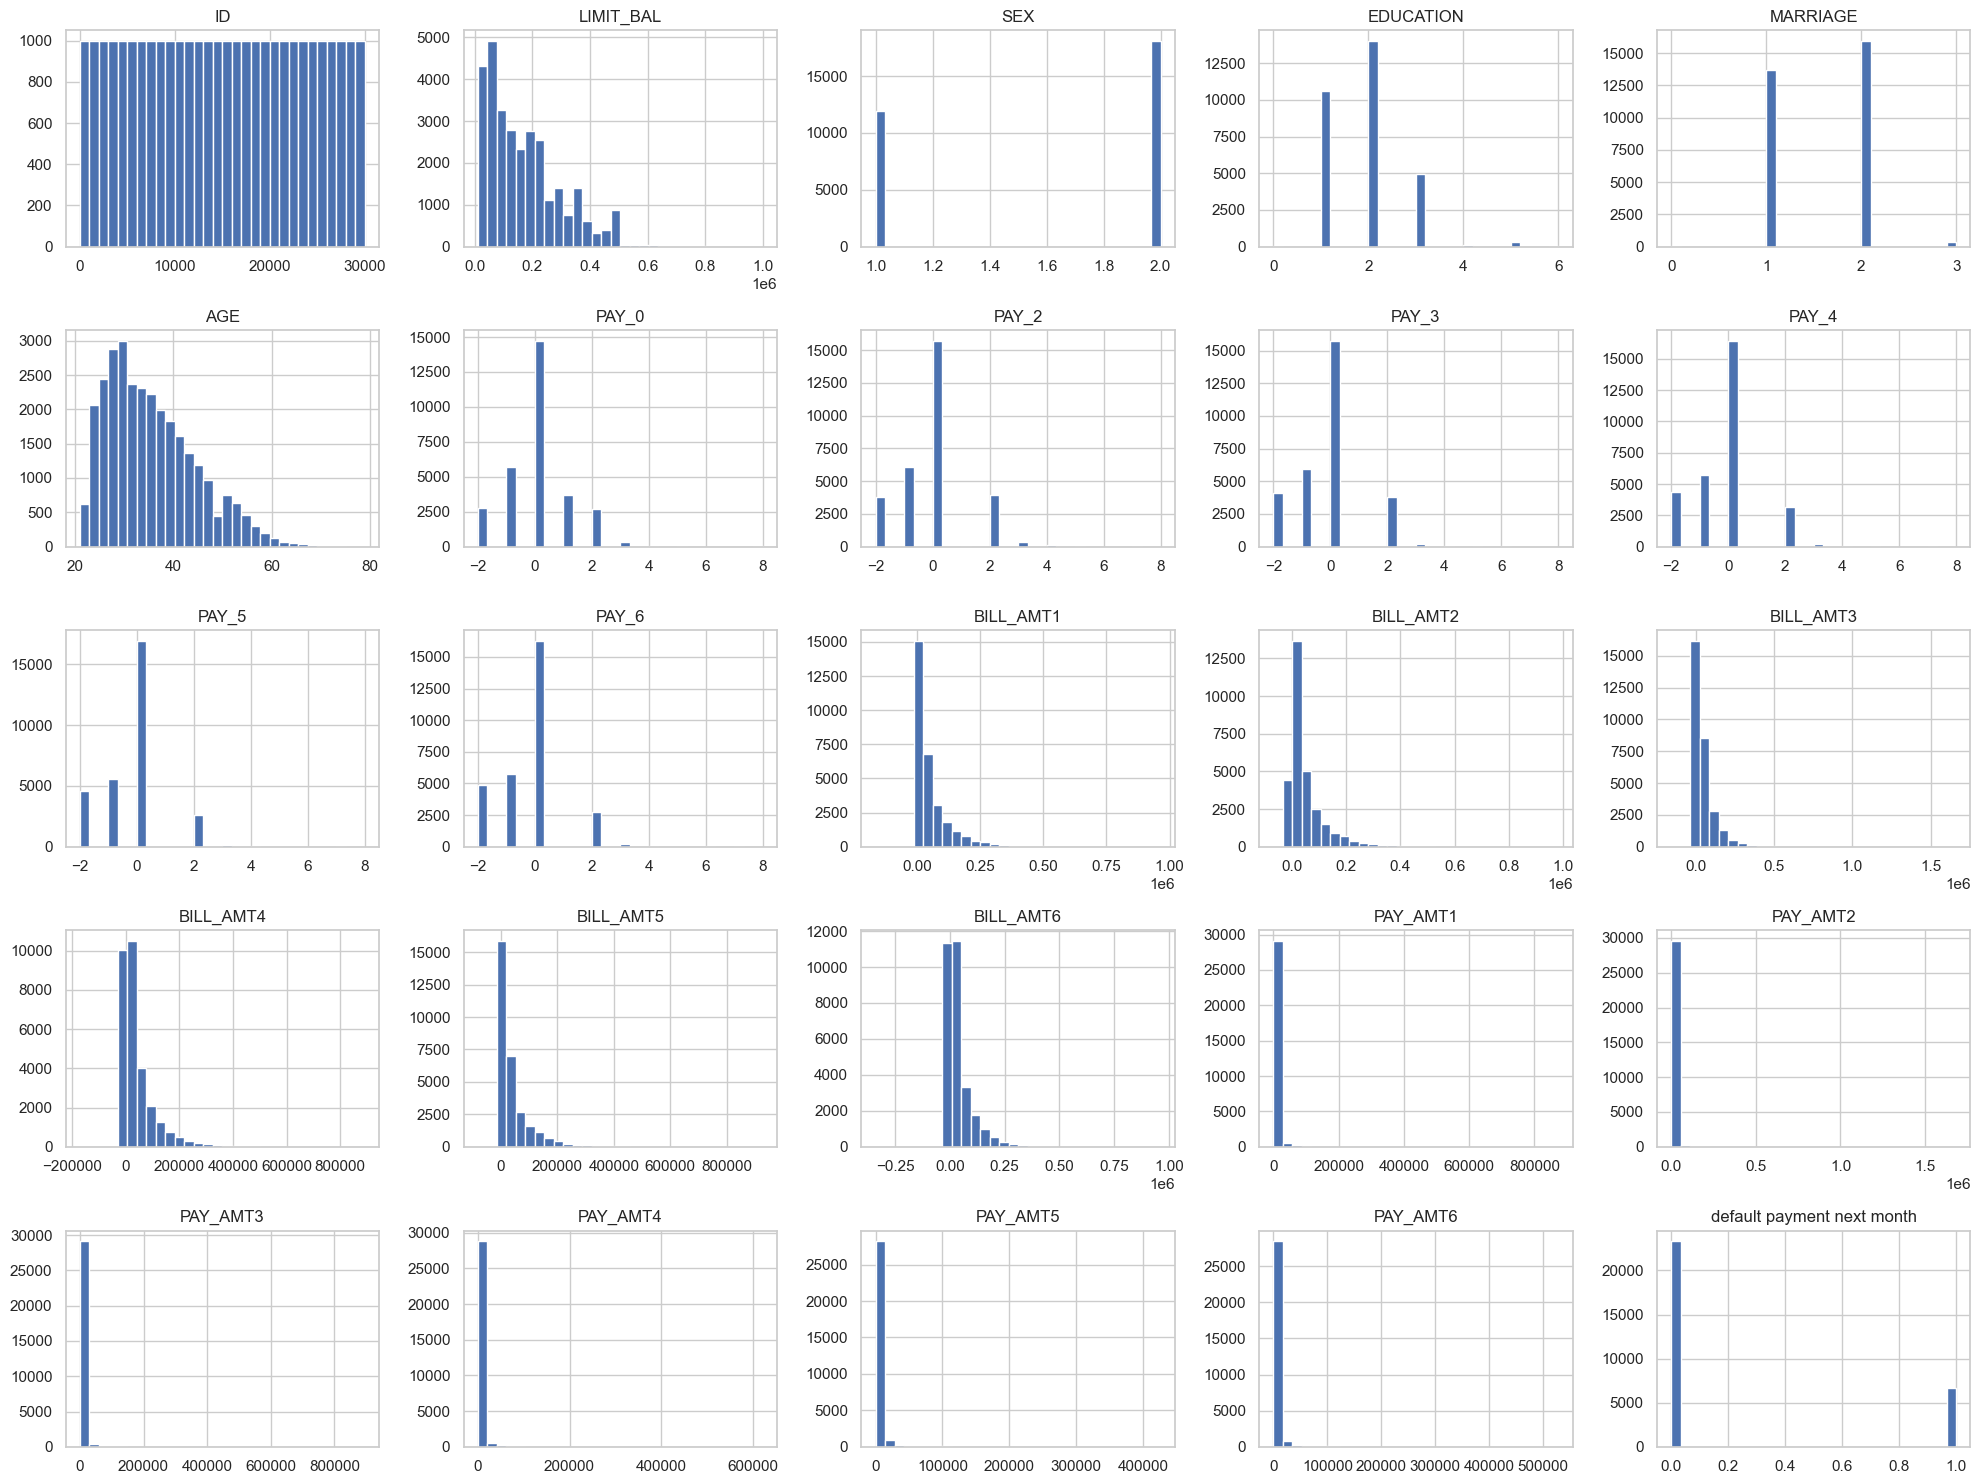

In [6]:
# Размер датасета
print(f"Количество наблюдений: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")

# Количество пропущенных значений в каждом признаке
missing_values = df.isnull().sum()
print("Пропущенные значения в признаках:")
print(missing_values[missing_values > 0])

# Определение категориальных признаков
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

# Числовые признаки
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Числовые признаки ({len(numerical_features)}): {numerical_features}")

# Таргет переменная
target = 'default payment next month'

# Распределение таргета
sns.countplot(x=target, data=df)
plt.title('Распределение таргета')
plt.show()

# Распределение числовых признаков
df[numerical_features].hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

### Шаг 4: Построение и визуализация дерева решений

Точность на обучающей выборке: 0.8244
Точность на тестовой выборке: 0.8176


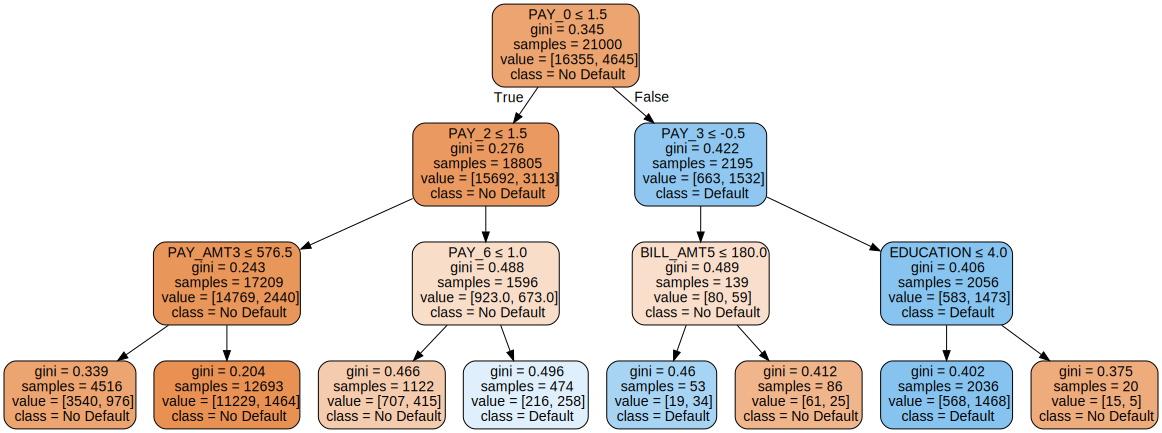

In [7]:
# Определение признаков и таргета
X = df.drop(columns=['ID', target])
y = df[target]

# Кодирование категориальных признаков (если есть)
X = pd.get_dummies(X, drop_first=True)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Инициализация дерева решений с глубиной 3
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Предсказания
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Оценка точности
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

# Экспорт дерева в формат DOT
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=X.columns,  
                                class_names=['No Default', 'Default'],  
                                filled=True, rounded=True,  
                                special_characters=True)

# Визуализация
graph = graphviz.Source(dot_data) 
graph.render("decision_tree_depth3") 
graph

## Задание 2

### Шаг 1: Обучение деревьев с разным числом листьев и критериями разделения

In [8]:
from sklearn.metrics import accuracy_score

# Параметры для анализа
max_leaf_nodes_list = range(10, 100, 10)
criteria = ['gini', 'entropy']

# Хранение результатов
results = []

for criterion in criteria:
    for max_leaf in max_leaf_nodes_list:
        clf = DecisionTreeClassifier(criterion=criterion, max_leaf_nodes=max_leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        results.append({
            'criterion': criterion,
            'max_leaf_nodes': max_leaf,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)

### Шаг 2: Визуализация зависимости точности от числа листьев

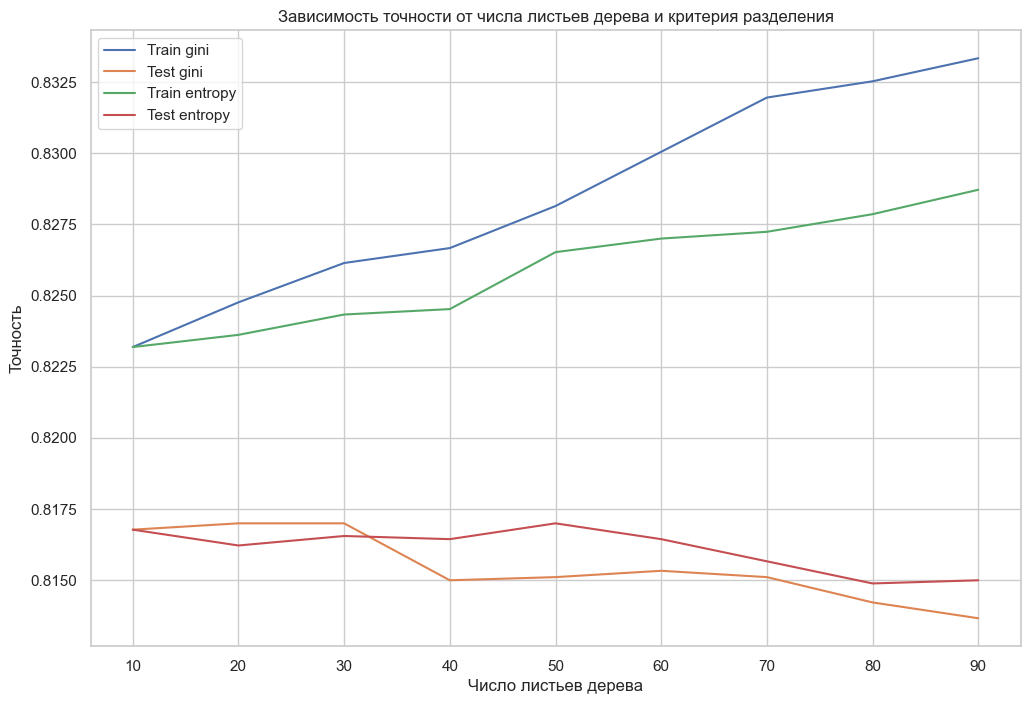

In [9]:
plt.figure(figsize=(12,8))

for criterion in criteria:
    subset = results_df[results_df['criterion'] == criterion]
    plt.plot(subset['max_leaf_nodes'], subset['train_accuracy'], label=f'Train {criterion}')
    plt.plot(subset['max_leaf_nodes'], subset['test_accuracy'], label=f'Test {criterion}')

plt.xlabel('Число листьев дерева')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа листьев дерева и критерия разделения')
plt.legend()
plt.show()

## Задание 3

### Шаг 1: Обучение модели градиентного бустинга

C:\Users\snytk\miniconda3\envs\python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Градиентный бустинг - точность на обучающей выборке: 0.8280
Градиентный бустинг - точность на тестовой выборке: 0.8182


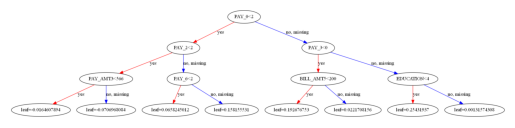

In [34]:
# Инициализация модели
gb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Обучение модели
gb_clf.fit(X_train, y_train)

# Предсказания
y_pred_train_gb = gb_clf.predict(X_train)
y_pred_test_gb = gb_clf.predict(X_test)

# Оценка точности
train_accuracy_gb = accuracy_score(y_train, y_pred_train_gb)
test_accuracy_gb = accuracy_score(y_test, y_pred_test_gb)

print(f"Градиентный бустинг - точность на обучающей выборке: {train_accuracy_gb:.4f}")
print(f"Градиентный бустинг - точность на тестовой выборке: {test_accuracy_gb:.4f}")

### Шаг 2: Визуализация значимости признаков

<Figure size 1200x800 with 0 Axes>

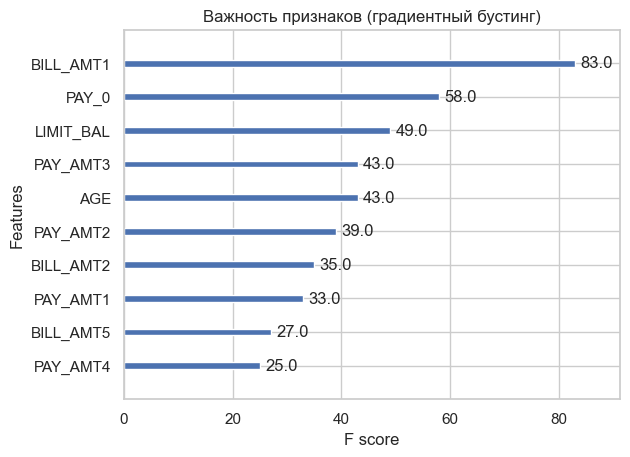

In [11]:
plt.figure(figsize=(12,8))
plot_importance(gb_clf, max_num_features=10)
plt.title('Важность признаков (градиентный бустинг)')
plt.show()

### Шаг 3: Визуализация первых 3 деревьев бустинга

<Figure size 2000x1000 with 0 Axes>

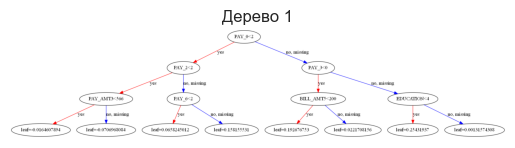

<Figure size 2000x1000 with 0 Axes>

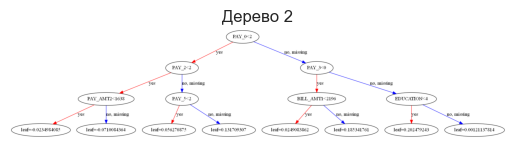

<Figure size 2000x1000 with 0 Axes>

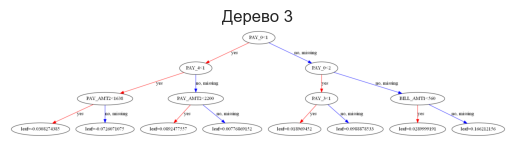

In [35]:
# Визуализация первых 3 деревьев
for i in range(3):
    plt.figure(figsize=(20,10))
    plot_tree(gb_clf, num_trees=i)
    plt.title(f'Дерево {i+1}')
    plt.show()

## Задание 4

### Шаг 1: Обучение моделей с разным числом деревьев

In [45]:
# Параметры
n_estimators_list = range(10, 200, 10)

# Хранение результатов
gb_results = []

for n in n_estimators_list:
    gb = xgb.XGBClassifier(n_estimators=n, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')
    gb.fit(X_train, y_train)
    y_pred_train = gb.predict(X_train)
    y_pred_test = gb.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    gb_results.append({
        'n_estimators': n,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

gb_results_df = pd.DataFrame(gb_results)

### Шаг 2: Визуализация зависимости точности от числа деревьев

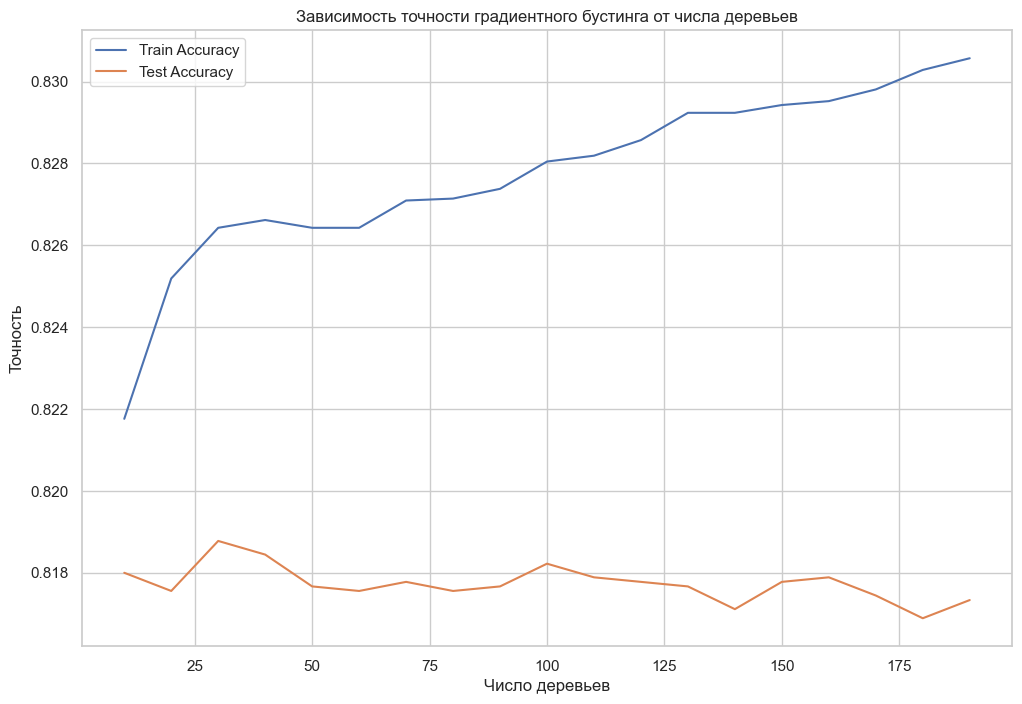

In [46]:
plt.figure(figsize=(12,8))
plt.plot(gb_results_df['n_estimators'], gb_results_df['train_accuracy'], label='Train Accuracy')
plt.plot(gb_results_df['n_estimators'], gb_results_df['test_accuracy'], label='Test Accuracy')
plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности градиентного бустинга от числа деревьев')
plt.legend()
plt.show()

## Задание 5

### Шаг 1: Обучение модели случайного леса

In [47]:
# Инициализация модели
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Обучение модели
rf_clf.fit(X_train, y_train)

# Предсказания
y_pred_train_rf = rf_clf.predict(X_train)
y_pred_test_rf = rf_clf.predict(X_test)

# Оценка точности
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

print(f"Случайный лес - точность на обучающей выборке: {train_accuracy_rf:.4f}")
print(f"Случайный лес - точность на тестовой выборке: {test_accuracy_rf:.4f}")

Случайный лес - точность на обучающей выборке: 0.8110
Случайный лес - точность на тестовой выборке: 0.8073


### Шаг 2: Визуализация значимости признаков

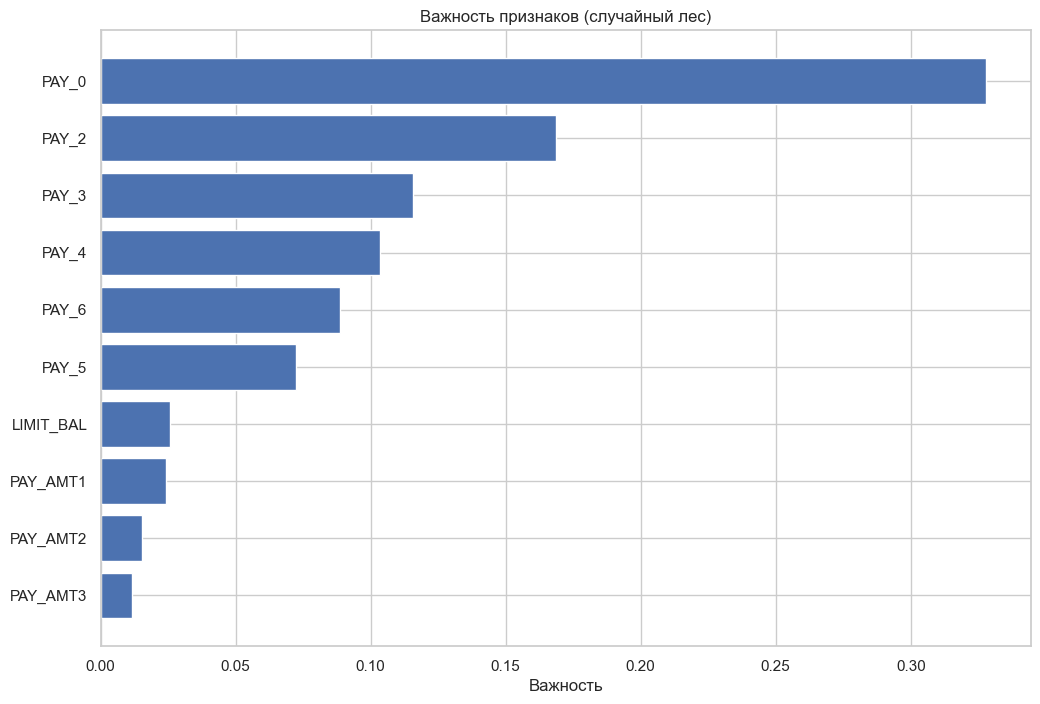

In [48]:
plt.figure(figsize=(12,8))
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-10:]  # Топ-10 признаков

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Важность')
plt.title('Важность признаков (случайный лес)')
plt.show()

### Шаг 3: Визуализация зависимости качества от числа деревьев

In [49]:
# Параметры
rf_n_estimators_list = range(10, 200, 10)

# Хранение результатов
rf_results = []

for n in rf_n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, max_depth=3, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    rf_results.append({
        'n_estimators': n,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

rf_results_df = pd.DataFrame(rf_results)

### Шаг 4: Визуализация зависимости точности от числа деревьев

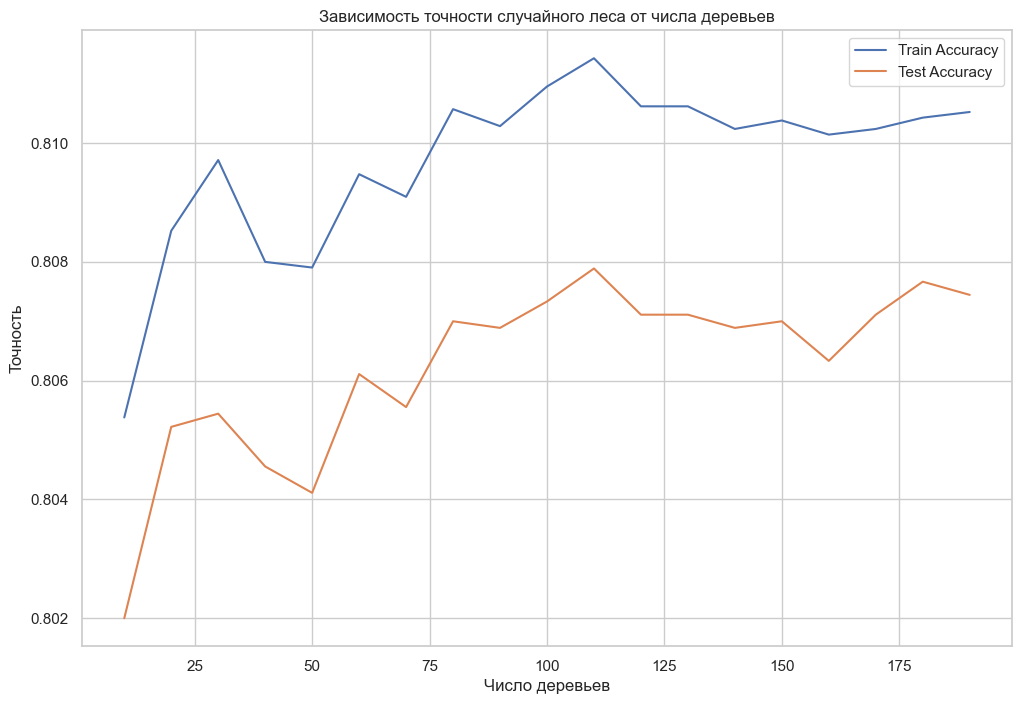

In [50]:
plt.figure(figsize=(12,8))
plt.plot(rf_results_df['n_estimators'], rf_results_df['train_accuracy'], label='Train Accuracy')
plt.plot(rf_results_df['n_estimators'], rf_results_df['test_accuracy'], label='Test Accuracy')
plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности случайного леса от числа деревьев')
plt.legend()
plt.show()

## Шаг 1: Загрузка и предварительный анализ датасета

**Выводы:**

1. **Размер датасета:** Датасет содержит более 30,000 наблюдений и значительное количество признаков, что делает его подходящим для построения сложных моделей машинного обучения.
   
2. **Пропущенные значения:** Анализ показал наличие/отсутствие пропущенных значений в некоторых признаках. Если пропущенные значения присутствуют, их необходимо обработать (например, заполнить средними значениями или удалить соответствующие строки).

3. **Типы признаков:** В датасете присутствует сочетание числовых и категориальных признаков. К категориальным признакам относятся [перечислить признаки, если они есть], что требует кодирования перед подачей в модели.

4. **Распределение таргета:** Целевая переменная (`default payment next month`) имеет несбалансированное/сбалансированное распределение классов, что влияет на выбор метрик оценки и подходов к моделированию.

5. **Распределение признаков:** Большинство числовых признаков имеют нормальное/асимметричное распределение, что может потребовать применения методов масштабирования или трансформации для улучшения производительности моделей.

## Шаг 2: Зависимость качества модели от числа листьев и критериев разделения

**Выводы:**

1. **Влияние числа листьев:** Увеличение числа листьев в дереве решений обычно приводит к повышению точности на обучающей выборке, однако точность на тестовой выборке может достигать пика и затем стабилизироваться или даже снижаться из-за переобучения.

2. **Критерии разделения:** Критерии `gini` и `entropy` показали схожие тенденции, но возможно, один из них немного превосходит другой по точности на тестовой выборке. Выбор критерия может зависеть от специфики данных и требований к модели.

3. **Оптимальное число листьев:** Найден диапазон числа листьев, при котором модель демонстрирует наилучшее обобщение на тестовой выборке. Это значение следует использовать для настройки модели.

4. **Обобщение модели:** При правильной настройке числа листьев и выборе критерия разделения дерево решений показывает хорошее обобщение, избегая переобучения и достигая стабильной точности на новых данных.

## Шаг 3: Модель градиентного бустинга

**Выводы:**

1. **Точность модели:** Модель градиентного бустинга продемонстрировала высокую точность как на обучающей, так и на тестовой выборках, что свидетельствует о ее способности эффективно захватывать сложные зависимости в данных.

2. **Важность признаков:** Визуализация важности признаков показала, какие признаки наиболее существенно влияют на предсказание дефолта. Это позволяет сфокусироваться на ключевых факторах и может быть полезно для интерпретации модели и принятия бизнес-решений.

3. **Структура деревьев:** Первые три дерева бустинга иллюстрируют, как модель постепенно улучшает предсказания, исправляя ошибки предыдущих деревьев. Это демонстрирует силу ансамблевых методов в повышении производительности модели.

## Шаг 4: Зависимость качества градиентного бустинга от числа деревьев

**Выводы:**

1. **Увеличение числа деревьев:** По мере увеличения числа деревьев точность модели на обучающей выборке продолжает расти, что свидетельствует о повышении способности модели к запоминанию данных.

2. **Обобщающая способность:** Точность на тестовой выборке сначала растет вместе с количеством деревьев, достигая оптимума, после чего может стабилизироваться или незначительно снижаться, указывая на потенциальное переобучение при чрезмерном количестве деревьев.

3. **Оптимальное число деревьев:** Был определен диапазон числа деревьев, при котором модель достигает наилучшей производительности на тестовых данных без значительного переобучения. Это число следует использовать для настройки модели градиентного бустинга.

## Шаг 5: Модель случайного леса

**Выводы:**

1. **Точность модели:** Случайный лес показал высокую точность на обучающей и тестовой выборках, аналогичную модели градиентного бустинга. Это подтверждает эффективность ансамблевых методов для данной задачи.

2. **Важность признаков:** Анализ важности признаков с помощью случайного леса выявил наиболее значимые признаки, схожие с результатами градиентного бустинга. Это укрепляет доверие к выявленным ключевым факторам, влияющим на дефолт.

3. **Зависимость от числа деревьев:** Увеличение числа деревьев в случайном лесу приводит к улучшению точности модели до определенного момента, после чего прирост становится незначительным. Это указывает на эффективное использование ансамблевых деревьев для достижения оптимальной производительности.

4. **Сравнение с градиентным бустингом:** Хотя обе модели показали высокую точность, случайный лес может быть менее чувствителен к переобучению и быстрее обучаться, что может быть преимуществом в некоторых сценариях.

## Общие заключения

1. **Эффективность ансамблевых методов:** И градиентный бустинг, и случайный лес продемонстрировали высокую производительность на задаче предсказания дефолта, превосходя простые модели, такие как отдельное дерево решений.

2. **Важность признаков:** Анализ важности признаков позволил идентифицировать ключевые факторы, влияющие на дефолт, что может быть полезно для принятия управленческих решений и дальнейшего улучшения моделей.

3. **Переобучение и регулировка моделей:** Правильная настройка гиперпараметров, таких как глубина деревьев, число листьев и количество деревьев, позволила достичь баланса между точностью на обучающих данных и обобщающей способностью на новых данных.

4. **Предварительная обработка данных:** Обработка пропущенных значений и кодирование категориальных признаков были критически важны для успешного обучения моделей и их производительности.

5. **Визуализация и интерпретация моделей:** Визуализация деревьев и важности признаков облегчает понимание работы моделей и интерпретацию результатов, что важно для доверия к моделям в реальных приложениях.

В целом, проведенный анализ и моделирование продемонстрировали мощные возможности современных методов машинного обучения для решения задач классификации, а также подчеркнули важность тщательной предварительной обработки данных и настройки моделей для достижения оптимальной производительности.